In [1]:
# Cell 1
import time

In [2]:
import random
import numpy as np
import dask.dataframe as dd
from dask.distributed import Client
from dask_cuda import LocalCUDACluster
start_time = time.time()
# Reproducibility
random.seed(42)
np.random.seed(42)

# GPU-aware Dask cluster (1 worker on your RTX 4080) :contentReference[oaicite:2]{index=2}
cluster = LocalCUDACluster()
client  = Client(cluster)
print(client)


<Client: 'tcp://127.0.0.1:42865' processes=1 threads=1, memory=30.49 GiB>


In [ ]:
themes = {
    # Branching narrative and emotional beats
    'story': [
        'story', 'plot', 'narrative', 'pacifist', 'genocide', 'neutral',
        'branching', 'ending', 'choice', 'consequence', 'moral',
        'friendship', 'redemption', 'hope', 'love', 'loss', 'memory',
        'determination'
    ],

    # Cast of monsters, humans, and the player avatar
    'characters': [
        'character', 'frisk', 'chara', 'sans', 'papyrus', 'toriel',
        'asgore', 'alphys', 'undyne', 'mettaton', 'flowey', 'asriel',
        'napstablook', 'monster kid', 'temmie', 'burgerpants',
        'npc', 'relationship', 'backstory'
    ],

    # Core RPG systems and moment‑to‑moment interaction
    'gameplay': [
        'gameplay', 'rpg', 'adventure', 'exploration', 'puzzle',
        'bullet hell', 'dodging', 'timing', 'menu', 'save', 'load',
        'checkpoint', 'inventory', 'quest', 'side quest', 'boss fight'
    ],

    # Turn‑based battles, ACT options, and mercy mechanics
    'combat': [
        'combat', 'battle', 'fight', 'act', 'mercy', 'spare', 'talk',
        'attack', 'defense', 'hp', 'exp', 'lv', 'soul', 'heart',
        'pattern', 'special attack', 'blue soul', 'green soul',
        'orange soul', 'purple soul', 'yellow soul'
    ],

    # Iconic chiptune OST by Toby Fox
    'music': [
        'music', 'soundtrack', 'ost', 'song', 'track', 'theme', 'melody',
        'motif', 'chiptune', 'chip‑tune', 'Megalovania', 'Hopes and Dreams',
        'His Theme', 'Undertale OST', 'piano', '8‑bit', 'orchestral'
    ],

    # Retro pixel art presentation and UI
    'visuals': [
        'visuals', 'graphics', 'sprite', 'pixel art', 'retro', 'color',
        'palette', 'animation', 'effect', 'lighting', 'ui', 'hud',
        'text box', 'portrait', 'scanline', 'CRT'
    ],

    # Signature humor, meta commentary, and fourth‑wall breaks
    'humor_dialogue': [
        'humor', 'dialogue', 'pun', 'joke', 'quirky', 'whimsical',
        'meta', 'fourth wall', 'narrator', 'sarcasm', 'flavor text',
        'reference', 'running gag', 'comic timing'
    ],

    # Moral philosophy, player agency, and in‑game judgment
    'morality': [
        'morality', 'ethics', 'choice', 'consequence', 'violence',
        'mercy', 'guilt', 'atonement', 'judgment hall', 'sins',
        'player agency', 'self‑reflection'
    ],

    # Hidden events, ARG elements, and file manipulation
    'secrets_meta': [
        'secret', 'hidden', 'easter egg', 'gaster', 'fun value',
        'mystery door', 'alternate route', 'hard mode', 'reset',
        'true lab', 'file delete', 'save file', 'corruption',
        'exe', 'meta narrative'
    ],

    # Regions, set pieces, and environmental storytelling
    'warp': [
        'world', 'setting', 'underground', 'ruins', 'snowdin',
        'waterfall', 'hotland', 'core', 'new home', 'castle',
        'true lab', 'temmie village', 'river person', 'map',
        'environment', 'atmosphere'
    ]
}
n_themes = len(themes)


In [4]:
# Cell 4 (updated)
DF_PATH = '/home/rgmatr1x/Documents/projects/steamETL/src/Step_3_analysis/top_100_parquet/*.parquet'
df = dd.read_parquet(
    DF_PATH,
    columns=['review','votes_up','voted_up','review_language']
)

# Keep only English reviews
df = df[df.review_language == 'english']

# **Drop rows where review is null**  
df = df.dropna(subset=['review'])  

# Persist now that we've cleaned
df = df.persist()
print("Partitions:", df.npartitions)
print("Total reviews:", df.review.count().compute())


Partitions: 15
Total reviews: 5645316


In [5]:
# ─── Cell 5: Text → sparse vectors (HashingVectorizer) ─────────────────────

# 0) Drop missing & ensure strings
df = df.dropna(subset=['review']).persist()
df = df.assign(review=df.review.astype(str)).persist()

# 1) Hashing trick → sparse Dask Array
from dask_ml.feature_extraction.text import HashingVectorizer
vec = HashingVectorizer(
    n_features=2**19,
    alternate_sign=False,
    stop_words='english',
    dtype=np.float32
)
X = vec.fit_transform(df.review)      # Dask Array of CSR blocks
print("🔷 hashed features:", X.shape)

# No more SVD here!


🔷 hashed features: (nan, 524288)


In [6]:
# ─── Fixed Cell 6: Seed your six themes & run Incremental MiniBatchKMeans ────

import numpy as np
from sklearn.cluster import MiniBatchKMeans
from dask_ml.wrappers import Incremental

# 1) Build pseudo-documents and vectorise (local SciPy CSR)
pseudo_docs = [" ".join(v) for v in themes.values()]
pseudo_h    = vec.transform(pseudo_docs)   # SciPy sparse, shape (6, 524288)

# 2) Dense-ify each row to form initial centroids array of shape (6, 524288)
pseudo_centroids = np.vstack([row.toarray().ravel() for row in pseudo_h])

# 3) Set up MiniBatchKMeans with your theme centroids
mbkm = MiniBatchKMeans(
    n_clusters=n_themes,
    init=pseudo_centroids,
    n_init=1,
    random_state=42,
    batch_size=10_000
)

# 4) Wrap with Dask-ML Incremental for out-of-core fitting
predict_meta = np.zeros(1, dtype=int)
km_inc = Incremental(mbkm, predict_meta=predict_meta)

# 5) Fit on each sparse block, then predict labels
km_inc.fit(X)
labels = km_inc.predict(X)   # Dask Array of length ≈1.37 M

# 6) Attach cluster IDs back to DataFrame
df2 = df.assign(topic_id=labels).persist()
print("Clustered into", n_themes, "handcrafted themes")


/home/rgmatr1x/anaconda3/envs/rapids-25.04/lib/python3.12/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 20.01 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Clustered into 10 handcrafted themes


/home/rgmatr1x/anaconda3/envs/rapids-25.04/lib/python3.12/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 41.44 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [7]:
# ─── Cell 7: Compute per-theme counts & like ratios ───────────────────────────

import pandas as pd

# 1) Count total reviews per theme
counts = df2.groupby('topic_id').review.count().compute()

# 2) Count likes per theme
likes  = df2[df2.voted_up].groupby('topic_id').review.count().compute()

# 3) Build summary table
summary = pd.DataFrame({
    'Theme':     list(themes.keys()),
    '#Reviews':  counts.values,
    'LikeRatio': (likes / counts * 100).round(1).astype(str) + '%'
})

# 4) Sort for presentation
summary = summary.sort_values('#Reviews', ascending=False).reset_index(drop=True)
display(summary)


,Theme,#Reviews,LikeRatio
0,characters,1757076,89.1%
1,warp,1148728,85.3%
2,combat,598480,85.2%
3,visuals,472419,97.4%
4,secrets_meta,417907,96.8%
5,humor_dialogue,345571,82.4%
6,morality,332874,85.1%
7,gameplay,301101,98.6%
8,story,213127,97.4%
9,music,58033,94.5%


In [8]:
import pandas as pd

# Compute counts & likes per cluster
counts = df2.groupby('topic_id').review.count().compute()
likes  = df2[df2.voted_up].groupby('topic_id').review.count().compute()

summary = pd.DataFrame({
    'Theme':      list(themes.keys()),
    '#Reviews':   counts.values,
    'LikeRatio':  (likes/counts*100).round(1).astype(str) + '%'
})
summary = summary.sort_values('#Reviews', ascending=False).reset_index(drop=True)
summary


,Theme,#Reviews,LikeRatio
0,characters,1757076,89.1%
1,warp,1148728,85.3%
2,combat,598480,85.2%
3,visuals,472419,97.4%
4,secrets_meta,417907,96.8%
5,humor_dialogue,345571,82.4%
6,morality,332874,85.1%
7,gameplay,301101,98.6%
8,story,213127,97.4%
9,music,58033,94.5%


In [9]:
# ─── Cell 9: Extract top keywords & example reviews via TF-IDF ────────────────

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# 1) Pull labels and reviews into Pandas for sampling
pdf = df2[['topic_id','votes_up','review']].compute()

# 2) For each handcrafted theme, sample up to 10k reviews
cluster_samples = {}
for tid in range(n_themes):
    docs = pdf.loc[pdf.topic_id == tid, 'review']
    # if >10k, sample 10k; else take all
    cluster_samples[tid] = docs.sample(
        n=min(len(docs), 10000),
        random_state=42
    ).tolist()

# 3) Fit a TF-IDF on the pooled samples (max 60k docs) with a limited vocab
all_docs = [d for docs in cluster_samples.values() for d in docs]
tfv = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1,2)
)
tfidf = tfv.fit_transform(all_docs)  # shape ≈ (≤60k, 5000)

# 4) Compute a centroid & top-10 terms per cluster
keywords = {}
offset = 0
for tid, docs in cluster_samples.items():
    m = tfidf[offset:offset+len(docs)]
    centroid = m.mean(axis=0).A1
    topn = centroid.argsort()[-10:][::-1]
    keywords[tid] = [tfv.get_feature_names_out()[i] for i in topn]
    offset += len(docs)

# 5) Find the highest-voted example per cluster
best_idxs = pdf.groupby('topic_id')['votes_up'].idxmax()
examples = pdf.loc[best_idxs, ['topic_id','review']].set_index('topic_id')

# 6) Build your final report DataFrame
report = pd.DataFrame({
    'Theme':       list(themes.keys()),
    '#Reviews':    [len(pdf[pdf.topic_id==tid]) for tid in range(n_themes)],
    'LikeRatio':   [
        f"{(pdf.loc[pdf.topic_id==tid,'votes_up'].sum() / len(pdf[pdf.topic_id==tid]) * 100):.1f}%"
        for tid in range(n_themes)
    ],
    'TopKeywords': [", ".join(keywords[tid]) for tid in range(n_themes)],
    'ExampleReview': [examples.loc[tid,'review'] for tid in range(n_themes)]
})
display(report.sort_values('#Reviews', ascending=False).reset_index(drop=True))


,Theme,#Reviews,LikeRatio,TopKeywords,ExampleReview
0,characters,1757076,202.0%,"yes, 1010, nice, cool, amazing, better, gud, a...",topic_id 1 h1Sneak regional pricing hike Ba...
1,warp,1148728,257.7%,"game, great, great game, amazing, like, just, ...",topic_id 9 I love this game so much but I a...
2,combat,598480,384.2%,"great, game, story, really, time, like, games,...",topic_id 3 Audience Kids Everyone Casual pl...
3,visuals,472419,97.2%,"good, good game, game, game good, pretty good,...",topic_id 5 Graphics Perfect Beautiful Good ...
4,secrets_meta,417907,56.6%,"fun, fun game, game, game fun, really fun, fri...",topic_id 8 great game not too much replay w...
5,humor_dialogue,345571,287.7%,"like, just, game, dont, games, im, good, play,...",topic_id 6 W game i would like to see porta...
6,morality,332874,186.7%,"play, game, game play, play game, friends, fun...",topic_id 7 Alright lets get this out of the...
7,gameplay,301101,119.2%,"best, best game, game, played, games, best gam...",topic_id 2 This is one of the best if not t...
8,story,213127,98.8%,"love, love game, game, game love, great, amazi...",topic_id 0 A love story about 4 men and the...
9,music,58033,141.3%,"bit, game, little, little bit, fun, good, grea...",topic_id 4 Meh the fun only lasts for a lit...


In [10]:
from transformers import pipeline

summarizer = pipeline(
    'summarization',
    model='sshleifer/distilbart-cnn-12-6',
    device=0
)

def safe_sum(text):
    try:
        return summarizer(text, max_length=40, min_length=15, do_sample=False)[0]['summary_text']
    except:
        return text[:200] + '…'

report['Summary'] = report.ExampleReview.map(safe_sum)
report


Device set to use cuda:0


,Theme,#Reviews,LikeRatio,TopKeywords,ExampleReview,Summary
0,story,213127,98.8%,"love, love game, game, game love, great, amazi...",topic_id 0 A love story about 4 men and the...,topic_id 0 A love story about 4 men and the...
1,characters,1757076,202.0%,"yes, 1010, nice, cool, amazing, better, gud, a...",topic_id 1 h1Sneak regional pricing hike Ba...,topic_id 1 h1Sneak regional pricing hike Ba...
2,gameplay,301101,119.2%,"best, best game, game, played, games, best gam...",topic_id 2 This is one of the best if not t...,topic_id 2 This is one of the best if not t...
3,combat,598480,384.2%,"great, game, story, really, time, like, games,...",topic_id 3 Audience Kids Everyone Casual pl...,topic_id 3 Audience Kids Everyone Casual pl...
4,music,58033,141.3%,"bit, game, little, little bit, fun, good, grea...",topic_id 4 Meh the fun only lasts for a lit...,topic_id 4 Meh the fun only lasts for a lit...
5,visuals,472419,97.2%,"good, good game, game, game good, pretty good,...",topic_id 5 Graphics Perfect Beautiful Good ...,topic_id 5 Graphics Perfect Beautiful Good ...
6,humor_dialogue,345571,287.7%,"like, just, game, dont, games, im, good, play,...",topic_id 6 W game i would like to see porta...,topic_id 6 W game i would like to see porta...
7,morality,332874,186.7%,"play, game, game play, play game, friends, fun...",topic_id 7 Alright lets get this out of the...,topic_id 7 Alright lets get this out of the...
8,secrets_meta,417907,56.6%,"fun, fun game, game, game fun, really fun, fri...",topic_id 8 great game not too much replay w...,topic_id 8 great game not too much replay w...
9,warp,1148728,257.7%,"game, great, great game, amazing, like, just, ...",topic_id 9 I love this game so much but I a...,topic_id 9 I love this game so much but I a...


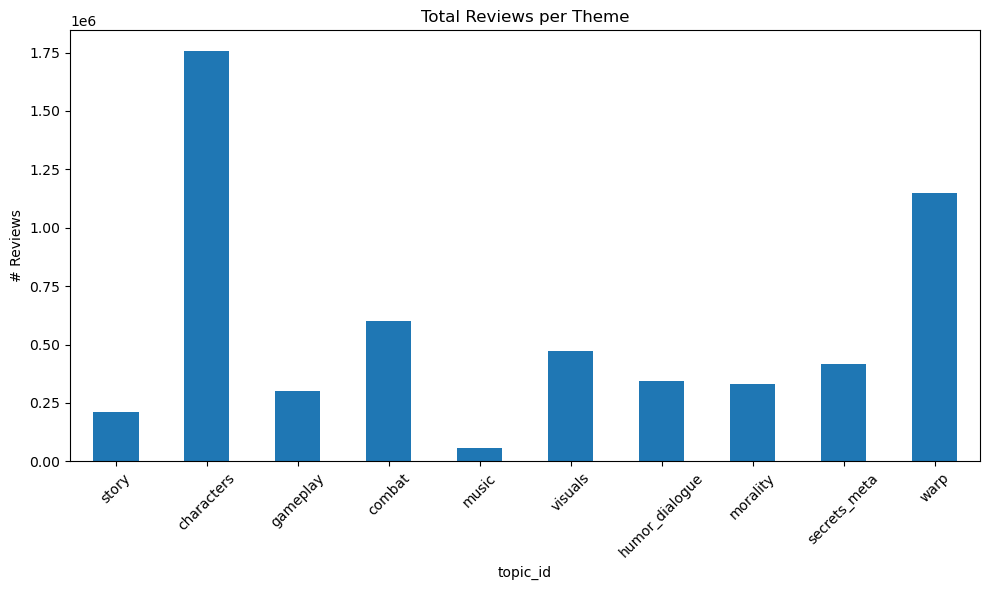

Time Taken: 149.66964030265808


In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
df2.groupby(['topic_id']).review.count().compute().rename(index=dict(enumerate(themes.keys()))) \
   .plot(kind='bar')
plt.title("Total Reviews per Theme")
plt.ylabel("# Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
end_time = time.time()

print("Time Taken:",(end_time - start_time))
